In [40]:
import numpy as np
import pandas as pd

from datetime import datetime
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from sktime.utils.plotting import plot_series

import mplfinance as mpf
from prophet import Prophet
from prophet.plot import plot_plotly, add_changepoints_to_plot
import pmdarima as pm
from pmdarima.arima.utils import ndiffs

import warnings
warnings.simplefilter('ignore')
from tqdm import tqdm
tqdm.pandas()

import train_model as tm
import data_processing as dp
from data_loader import load_data_at_start_date, load_data_period
# from features import FeatureEngineering

In [2]:
df = dp.get_data('crypto_data', 'BTC-USD', compress=False) 
# display(df)

### Data analysis 

In [3]:
# handle missing value
for column, _ in df.items():
    if column == 'Volume' and df[column].isna().sum() > 0:
        df[column].fillna(value=0, inplace=True)
    elif not column == 'Volume' and df[column].isna().sum() > 0:
        df[column].fillna(method='ffill', inplace=True)

# display(df)
print(len(df))

2206


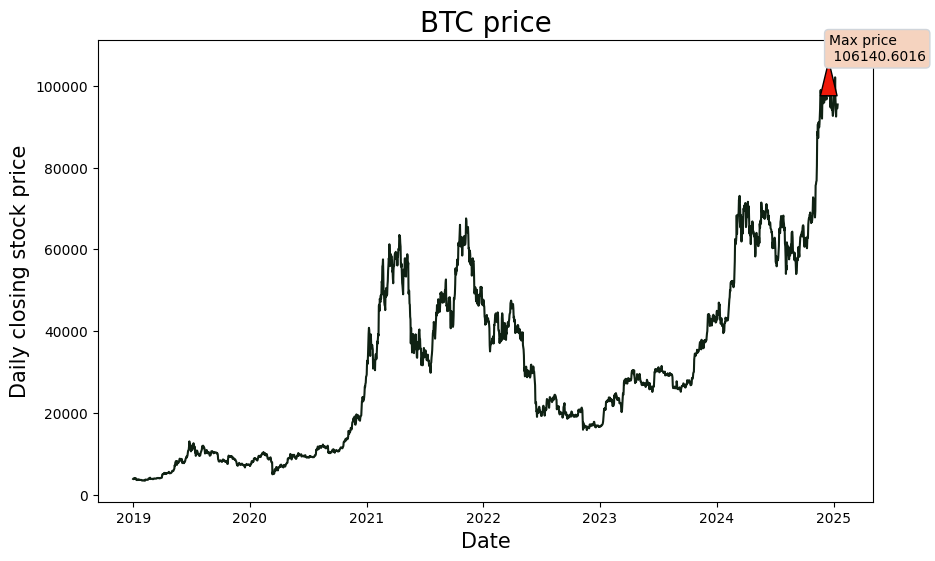

In [4]:
fig, ax = plt.subplots(figsize=(10,6))
high = df['Close'].max()
datetime = df[df['Close'] == df['Close'].max()].index.values

ax.plot(df.index, df['Close'], color='#0f2113')
ax.set_title("BTC price", fontsize=20)
ax.set_xlabel("Date", fontsize=15)
ax.set_ylabel("Daily closing stock price", fontsize=15)
ax.annotate(f"Max price\n {round(high, 4)}", xy=(datetime, high),xytext=(datetime,high-35),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))
plt.show()

### Вывод
- Тренд с 2023
- Шум в данных
- Не стационарный временной ряд

In [167]:
## Stationary test, Augmented Dicky-Fuller, p-value <= 0.05 stationary series
def adfuller_test(df):
    adfuller_result = adfuller(df['Close'], autolag='AIC')
    adfuller_output = pd.Series(adfuller_result[:4], index=['Test statistic', 'p-value',
                                                            'Lags Used','Number of Observations Used'])
    return adfuller_output

# find degree of differencing 
def degree_of_differencing(df, col_name, symbol):
    company_ndiffs = ndiffs(df[col_name], test = 'adf')
    print(f'The degree of differencing is {company_ndiffs} for {symbol}')
    
    return company_ndiffs

def adfuller_test2(df):
    adfuller_result = adfuller(df, autolag='AIC')
    adfuller_output = pd.Series(adfuller_result[:4], index=['Test statistic', 'p-value',
                                                            'Lags Used','Number of Observations Used'])
    return adfuller_output

# find degree of differencing 
def degree_of_differencing(df, symbol):
    company_ndiffs = ndiffs(df, test = 'adf')
    print(f'The degree of differencing is {company_ndiffs} for {symbol}')
    
    return company_ndiffs

In [ ]:
adfuller_test(df)
# p-value greater then 0.5

Test statistic                   -0.382163
p-value                           0.913035
Lags Used                        26.000000
Number of Observations Used    2179.000000
dtype: float64

In [ ]:
ddf = degree_of_differencing(df, 'Close', 'BTC-USD')
ddf

In [ ]:
## Check data
# df['Close'].plot(figsize=(14,6))
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.grid()
# plt.show()

### Removing trend

2205


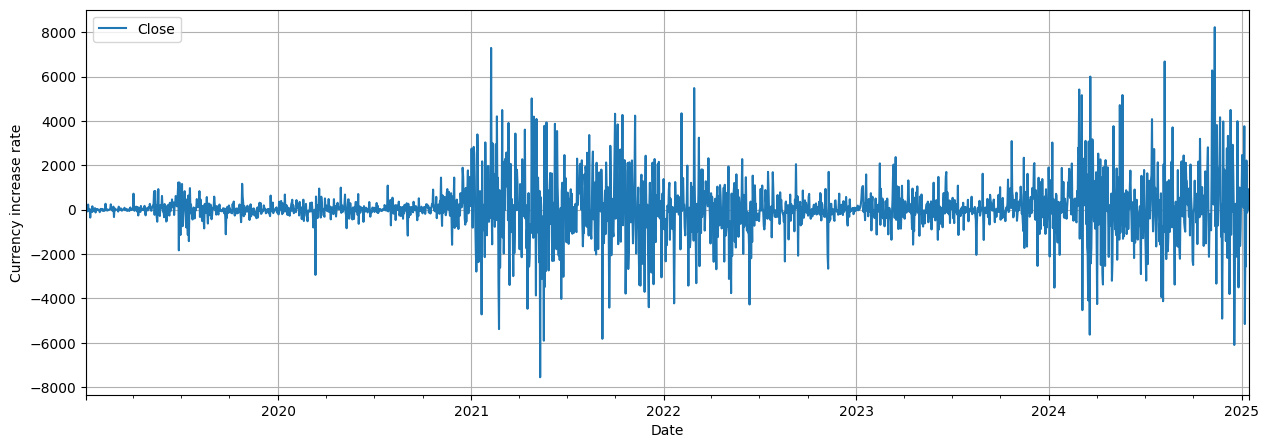

In [137]:
## Differencing
close_df = df[['Close']].copy()
close_df = close_df.diff()
close_df = close_df.dropna()
print(len(close_df))

## Plot the data to see the outcome
close_df.plot(figsize=(15,5))
plt.xlabel('Date')
plt.ylabel('Currency increase rate')
plt.grid()
plt.show()

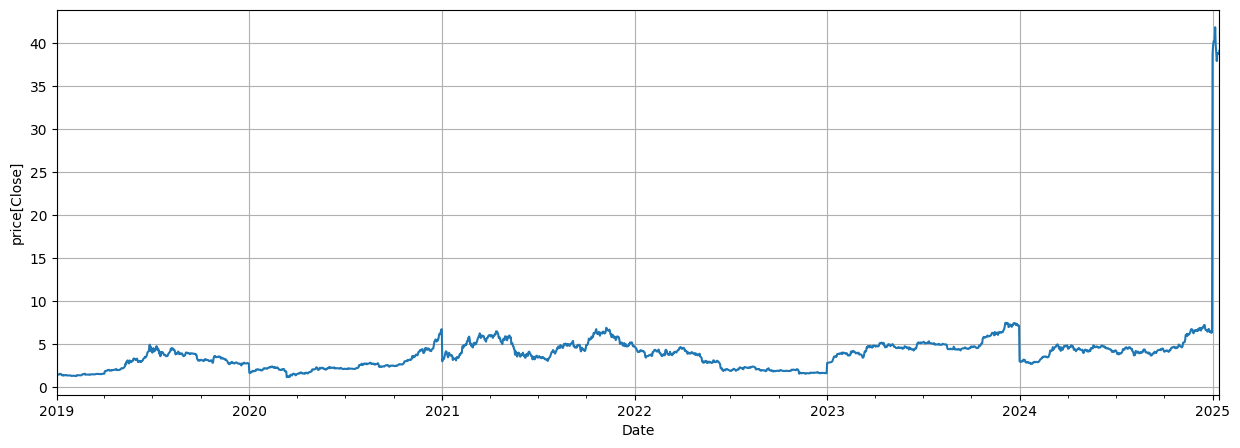

In [152]:
# Calculate each year's variance (equivalent to standard deviation)
close_df = df['Close']

annual_average = close_df.groupby(close_df.index.year).std()
mapped_annual_average = close_df.index.map(lambda x: annual_average.loc[x.year])
# month_average = close_df.groupby(close_df.index.month).std()
# mapped_month_average = close_df.index.map(lambda x: month_average.loc[x.month])

# type(close_df['Close'])
# close_df.reset_index(inplace=True)
# close_df = pd.Series(close_df['Close'])

# # Standardize each year's variance
close_df = close_df / mapped_annual_average
# close_df = close_df / mapped_month_average

# # Plot outcome
close_df.plot(figsize=(15,5))
plt.xlabel('Date')
plt.ylabel('price[Close]')
plt.grid()
plt.show()

### Remove seasonality

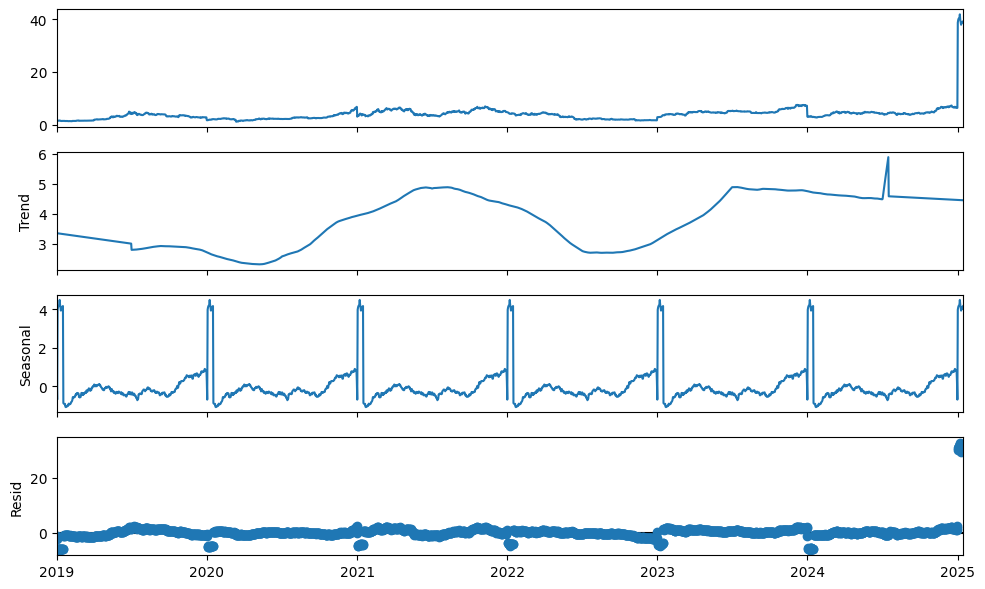

In [156]:
# result_decom = seasonal_decompose(df['Close'], model="multiplicative", period=365, extrapolate_trend='freq')
result_decom = seasonal_decompose(close_df, period=365, extrapolate_trend='freq')
# plot
fig = result_decom.plot()
fig.set_size_inches((10, 6))
fig.tight_layout()
plt.show()

### STL(Seasonal-Trend decomposition using LOESS)

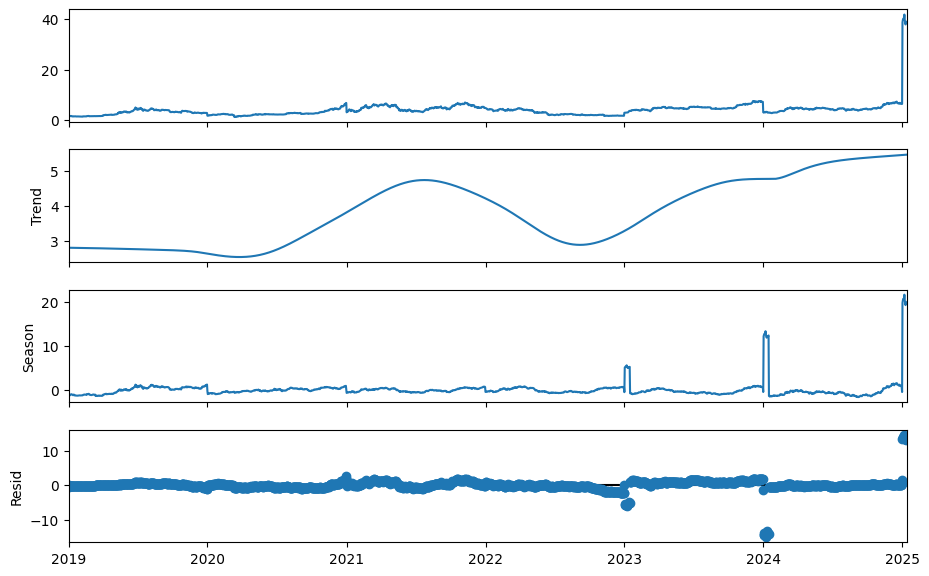

In [157]:
# stl = STL(df['Close'], period=365, trend_deg=0)
stl = STL(close_df, period=365, trend_deg=0)
res = stl.fit()
fig = res.plot()
fig.set_size_inches((10, 6))

In [168]:
# Perform ADF test
result = adfuller(close_df)
print('ADF test:\tp-value: {:.3f}'.format(result[1]))

# Perform KPSS test
result = kpss(close_df)
print('KPSS test:\tp-value: {:.3f}'.format(result[1]))


ADF test:	p-value: 0.988
KPSS test:	p-value: 0.010


Test statistic                    0.624497
p-value                           0.988204
Lags Used                         6.000000
Number of Observations Used    2199.000000
dtype: float64

In [171]:
# Apply one more differencing to the data
close_df = close_df.diff()[1:]

# Perform ADF test
result = adfuller(close_df)
print('ADF test:\tp-value: {:.3f}'.format(result[1]))

# Perform KPSS test
result = kpss(close_df)
print('KPSS test:\tp-value: {:.3f}'.format(result[1]))

adfuller_test2(close_df)


# close_df.plot(figsize=(15,5))
# plt.xlabel('Date')
# plt.ylabel('price[Close]')
# plt.grid()
# plt.show()

ADF test:	p-value: 0.000
KPSS test:	p-value: 0.100


Test statistic                  -20.426849
p-value                           0.000000
Lags Used                        26.000000
Number of Observations Used    2176.000000
dtype: float64

In [ ]:
# data = df.reset_index()
# close_df = data[['Date', 'Close']].copy();
# close_df.set_index('Date', inplace=True)
# print(close_df.isna().sum())
# close_df.dropna()

# train_size = len(close_df) * 4 // 5
# y_train = close_df[:train_size]
# y_test = close_df[train_size:]

# display(close_df)

In [165]:
# ets_aaa = sm.tsa.statespace.ExponentialSmoothing(close_df, trend=True,  seasonal=365, freq='Y')
ets_aaa = sm.tsa.statespace.ExponentialSmoothing(close_df, trend=True,  seasonal=24)
# ets_aaa_res = ets_aaa.fit()
ets_aaa_res = ets_aaa.fit(use_boxcox=True)
print(ets_aaa_res.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.77774D+00    |proj g|=  3.04377D-01

At iterate    5    f=  1.08404D+00    |proj g|=  1.91157D-02

At iterate   10    f=  1.07856D+00    |proj g|=  2.22175D-03

At iterate   15    f=  1.07797D+00    |proj g|=  1.24509D-03

At iterate   20    f=  1.07790D+00    |proj g|=  3.96114D-04

At iterate   25    f=  1.07787D+00    |proj g|=  3.62723D-04

At iterate   30    f=  1.07787D+00    |proj g|=  9.56329D-05

At iterate   35    f=  1.07787D+00    |proj g|=  7.62446D-05

At iterate   40    f=  1.07787D+00    |proj g|=  1.63834D-04

At iterate   45    f=  1.07781D+00    |proj g|=  1.30411D-03

At iterate   50    f=  1.07778D+00    |proj g|=  6.89103D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

NullFrequencyError: Cannot shift with no freq

In [ ]:
# Check for stationarity




result = adfuller(df)
print('ADF test:\tp-value: {:.3f}'.format(result[1]))

# Perform KPSS test
result = kpss(df)
print('KPSS test:\tp-value: {:.3f}'.format(result[1]))

# q = 0.0001
# lags = [1, 5, 10, 21, 42, 63]
# for lag in lags:
#     df[f'return_{lag}d'] = df.Close.pct_change(lag) \
#                             .pipe(lambda x: x.clip(lower=x.quantile(q),upper=x.quantile(1 - q))) \
#                             .add(1) \
#                             .pow(1 / lag) \
#                             .sub(1)

# for t in [1, 2, 3, 4, 5]:
#  for lag in [1, 5, 10, 21]:
#     df[f'return_{lag}d_lag{t}'] = df[f'return_{lag}d'].shift(t * lag)

# for t in [1, 5, 10, 21]:
#     df[f'target_{t}d'] = df[f'return_{t}d'].shift(-t)

# print(len(df))
# df.dropna(inplace=True)
# print(len(df))
# display(df)